In [3]:
!pip install yfinance -qq

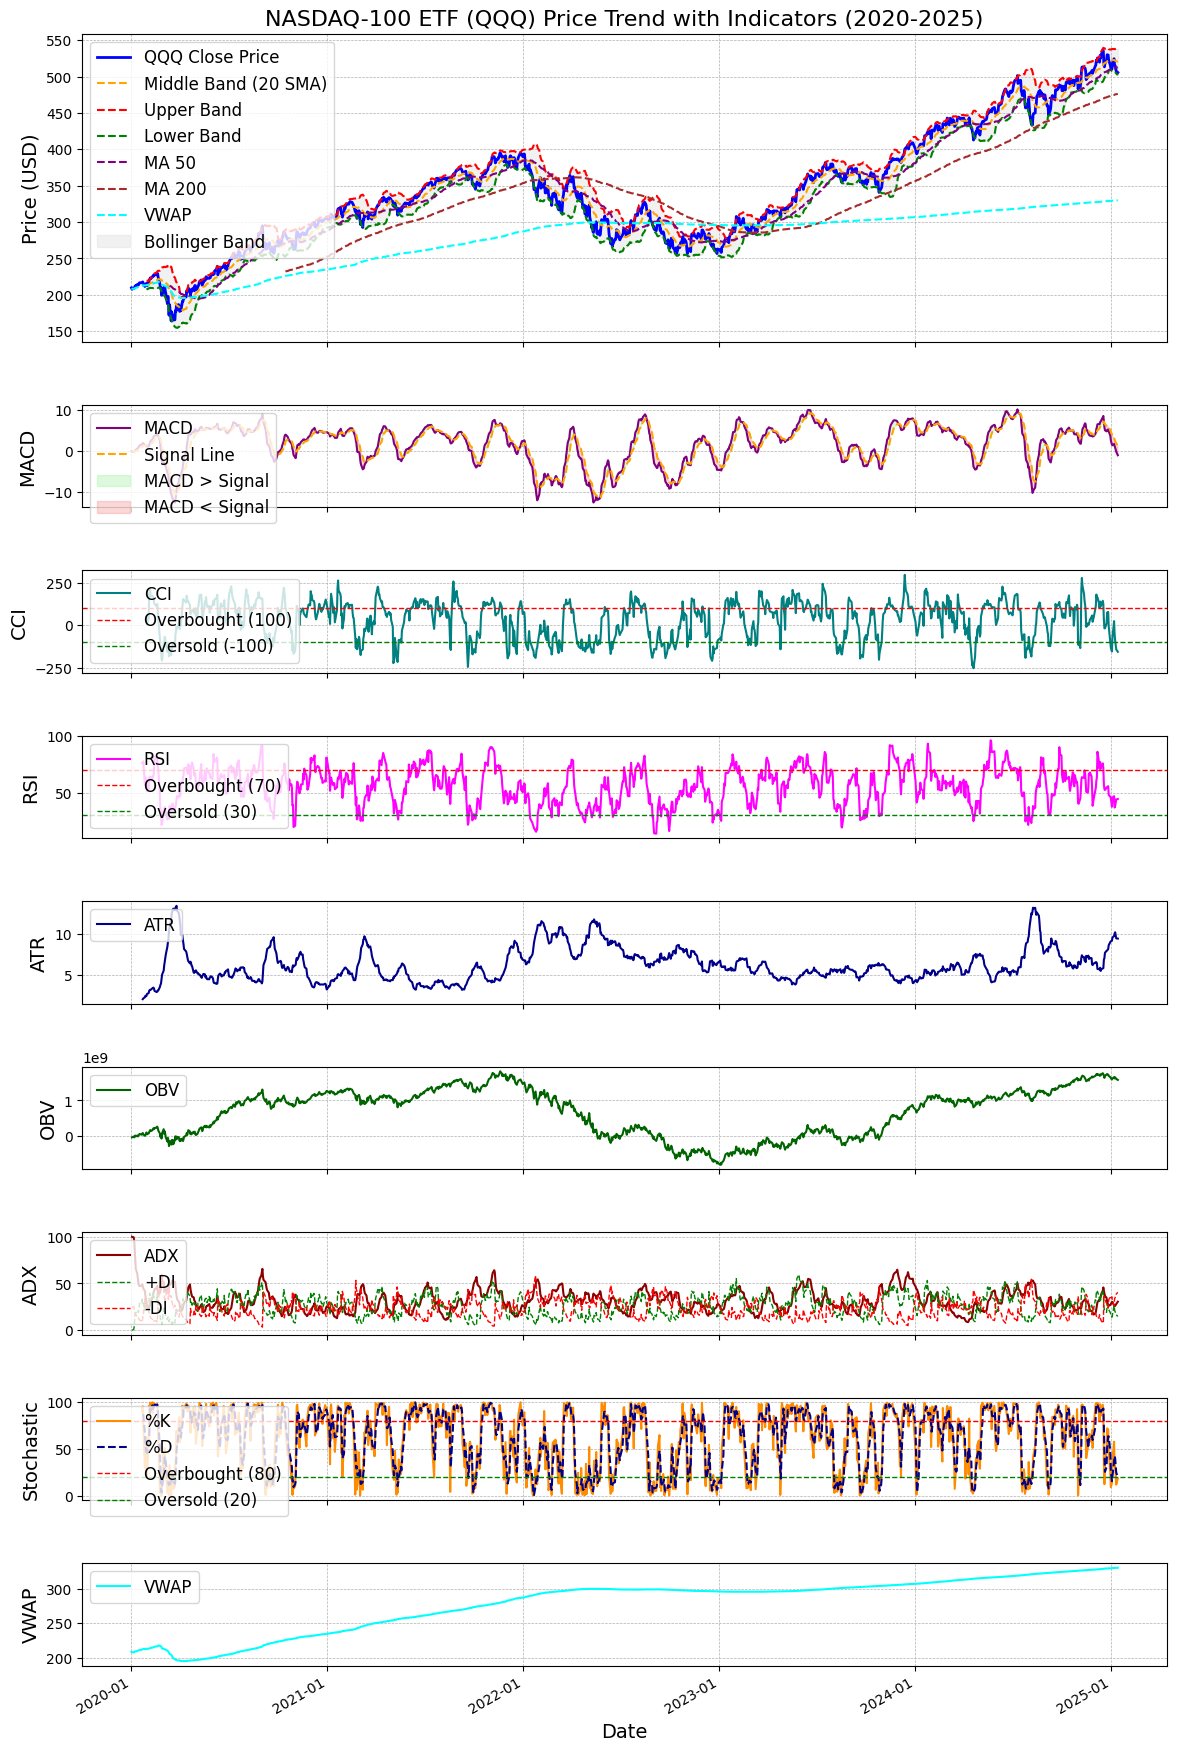

In [5]:
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from datetime import datetime

# 获取QQQ的历史数据
qqq = yf.Ticker("QQQ")
data = qqq.history(start="2020-01-01", end="2025-12-31")

# 计算布林带
window = 20  # 布林带窗口大小
data['Middle Band'] = data['Close'].rolling(window=window).mean()  # 中轨：20日移动平均线
data['Std Dev'] = data['Close'].rolling(window=window).std()  # 标准差
data['Upper Band'] = data['Middle Band'] + 2 * data['Std Dev']  # 上轨
data['Lower Band'] = data['Middle Band'] - 2 * data['Std Dev']  # 下轨

# 计算MACD
short_window = 12  # 短期EMA窗口
long_window = 26  # 长期EMA窗口
signal_window = 9  # 信号线窗口
data['Short EMA'] = data['Close'].ewm(span=short_window, adjust=False).mean()  # 短期EMA
data['Long EMA'] = data['Close'].ewm(span=long_window, adjust=False).mean()  # 长期EMA
data['MACD'] = data['Short EMA'] - data['Long EMA']  # MACD线
data['Signal Line'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()  # 信号线

# 计算CCI
def calculate_cci(data, window=20):
    typical_price = (data['High'] + data['Low'] + data['Close']) / 3
    mean_deviation = typical_price.rolling(window=window).apply(lambda x: np.mean(np.abs(x - np.mean(x))))
    cci = (typical_price - typical_price.rolling(window=window).mean()) / (0.015 * mean_deviation)
    return cci

data['CCI'] = calculate_cci(data)

# 计算RSI
def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

data['RSI'] = calculate_rsi(data)

# 计算移动平均线（MA）
data['MA_50'] = data['Close'].rolling(window=50).mean()  # 50日移动平均线
data['MA_200'] = data['Close'].rolling(window=200).mean()  # 200日移动平均线

# 计算ATR（平均真实波幅）
def calculate_atr(data, window=14):
    high_low = data['High'] - data['Low']
    high_close = np.abs(data['High'] - data['Close'].shift())
    low_close = np.abs(data['Low'] - data['Close'].shift())
    true_range = np.maximum(high_low, np.maximum(high_close, low_close))
    atr = true_range.rolling(window=window).mean()
    return atr

data['ATR'] = calculate_atr(data)

# 计算OBV（能量潮）
def calculate_obv(data):
    obv = (np.sign(data['Close'].diff()) * data['Volume']).cumsum()
    return obv

data['OBV'] = calculate_obv(data)

# 计算ADX（平均趋向指数）
def calculate_adx(data, window=14):
    plus_dm = data['High'].diff()
    minus_dm = -data['Low'].diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm < 0] = 0
    tr = np.maximum(data['High'] - data['Low'], np.maximum(np.abs(data['High'] - data['Close'].shift()), np.abs(data['Low'] - data['Close'].shift())))
    plus_di = 100 * (plus_dm.ewm(span=window, adjust=False).mean() / tr.ewm(span=window, adjust=False).mean())
    minus_di = 100 * (minus_dm.ewm(span=window, adjust=False).mean() / tr.ewm(span=window, adjust=False).mean())
    dx = 100 * np.abs(plus_di - minus_di) / (plus_di + minus_di)
    adx = dx.ewm(span=window, adjust=False).mean()
    return adx, plus_di, minus_di

data['ADX'], data['Plus DI'], data['Minus DI'] = calculate_adx(data)

# 计算Stochastic Oscillator（随机振荡器）
def calculate_stochastic(data, window=14, smooth_window=3):
    lowest_low = data['Low'].rolling(window=window).min()
    highest_high = data['High'].rolling(window=window).max()
    k = 100 * (data['Close'] - lowest_low) / (highest_high - lowest_low)
    d = k.rolling(window=smooth_window).mean()
    return k, d

data['%K'], data['%D'] = calculate_stochastic(data)

# 计算VWAP（成交量加权平均价格）
def calculate_vwap(data):
    vwap = (data['Volume'] * (data['High'] + data['Low'] + data['Close']) / 3).cumsum() / data['Volume'].cumsum()
    return vwap

data['VWAP'] = calculate_vwap(data)

# 创建图表布局
fig, axes = plt.subplots(9, 1, figsize=(14, 24), gridspec_kw={'height_ratios': [3, 1, 1, 1, 1, 1, 1, 1, 1]}, sharex=True)
plt.subplots_adjust(hspace=0.5)  # 调整子图间距

# 主图：价格、布林带和移动平均线
axes[0].plot(data.index, data['Close'], label='QQQ Close Price', color='blue', linewidth=2)
axes[0].plot(data.index, data['Middle Band'], label='Middle Band (20 SMA)', color='orange', linestyle='--', linewidth=1.5)
axes[0].plot(data.index, data['Upper Band'], label='Upper Band', color='red', linestyle='--', linewidth=1.5)
axes[0].plot(data.index, data['Lower Band'], label='Lower Band', color='green', linestyle='--', linewidth=1.5)
axes[0].plot(data.index, data['MA_50'], label='MA 50', color='purple', linestyle='--', linewidth=1.5)
axes[0].plot(data.index, data['MA_200'], label='MA 200', color='brown', linestyle='--', linewidth=1.5)
axes[0].plot(data.index, data['VWAP'], label='VWAP', color='cyan', linestyle='--', linewidth=1.5)
axes[0].fill_between(data.index, data['Upper Band'], data['Lower Band'], color='lightgray', alpha=0.3, label='Bollinger Band')
axes[0].set_title('NASDAQ-100 ETF (QQQ) Price Trend with Indicators (2020-2025)', fontsize=16)
axes[0].set_ylabel('Price (USD)', fontsize=14)
axes[0].legend(loc='upper left', fontsize=12)
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# MACD子图
axes[1].plot(data.index, data['MACD'], label='MACD', color='purple', linewidth=1.5)
axes[1].plot(data.index, data['Signal Line'], label='Signal Line', color='orange', linestyle='--', linewidth=1.5)
axes[1].fill_between(data.index, data['MACD'], data['Signal Line'], where=data['MACD'] > data['Signal Line'], color='lightgreen', alpha=0.3, label='MACD > Signal')
axes[1].fill_between(data.index, data['MACD'], data['Signal Line'], where=data['MACD'] < data['Signal Line'], color='lightcoral', alpha=0.3, label='MACD < Signal')
axes[1].set_ylabel('MACD', fontsize=14)
axes[1].legend(loc='upper left', fontsize=12)
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)

# CCI子图
axes[2].plot(data.index, data['CCI'], label='CCI', color='teal', linewidth=1.5)
axes[2].axhline(100, color='red', linestyle='--', linewidth=1, label='Overbought (100)')
axes[2].axhline(-100, color='green', linestyle='--', linewidth=1, label='Oversold (-100)')
axes[2].set_ylabel('CCI', fontsize=14)
axes[2].legend(loc='upper left', fontsize=12)
axes[2].grid(True, which='both', linestyle='--', linewidth=0.5)

# RSI子图
axes[3].plot(data.index, data['RSI'], label='RSI', color='magenta', linewidth=1.5)
axes[3].axhline(70, color='red', linestyle='--', linewidth=1, label='Overbought (70)')
axes[3].axhline(30, color='green', linestyle='--', linewidth=1, label='Oversold (30)')
axes[3].set_ylabel('RSI', fontsize=14)
axes[3].legend(loc='upper left', fontsize=12)
axes[3].grid(True, which='both', linestyle='--', linewidth=0.5)

# ATR子图
axes[4].plot(data.index, data['ATR'], label='ATR', color='darkblue', linewidth=1.5)
axes[4].set_ylabel('ATR', fontsize=14)
axes[4].legend(loc='upper left', fontsize=12)
axes[4].grid(True, which='both', linestyle='--', linewidth=0.5)

# OBV子图
axes[5].plot(data.index, data['OBV'], label='OBV', color='darkgreen', linewidth=1.5)
axes[5].set_ylabel('OBV', fontsize=14)
axes[5].legend(loc='upper left', fontsize=12)
axes[5].grid(True, which='both', linestyle='--', linewidth=0.5)

# ADX子图
axes[6].plot(data.index, data['ADX'], label='ADX', color='darkred', linewidth=1.5)
axes[6].plot(data.index, data['Plus DI'], label='+DI', color='green', linestyle='--', linewidth=1)
axes[6].plot(data.index, data['Minus DI'], label='-DI', color='red', linestyle='--', linewidth=1)
axes[6].set_ylabel('ADX', fontsize=14)
axes[6].legend(loc='upper left', fontsize=12)
axes[6].grid(True, which='both', linestyle='--', linewidth=0.5)

# Stochastic Oscillator子图
axes[7].plot(data.index, data['%K'], label='%K', color='darkorange', linewidth=1.5)
axes[7].plot(data.index, data['%D'], label='%D', color='darkblue', linestyle='--', linewidth=1.5)
axes[7].axhline(80, color='red', linestyle='--', linewidth=1, label='Overbought (80)')
axes[7].axhline(20, color='green', linestyle='--', linewidth=1, label='Oversold (20)')
axes[7].set_ylabel('Stochastic', fontsize=14)
axes[7].legend(loc='upper left', fontsize=12)
axes[7].grid(True, which='both', linestyle='--', linewidth=0.5)

# VWAP子图
axes[8].plot(data.index, data['VWAP'], label='VWAP', color='cyan', linewidth=1.5)
axes[8].set_ylabel('VWAP', fontsize=14)
axes[8].set_xlabel('Date', fontsize=14)
axes[8].legend(loc='upper left', fontsize=12)
axes[8].grid(True, which='both', linestyle='--', linewidth=0.5)

# 设置日期格式
axes[8].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axes[8].xaxis.set_major_locator(mdates.YearLocator())
fig.autofmt_xdate()

# 保存图表到当前目录
# plt.savefig('qqq_price_trend_with_even_more_indicators_2020_2025.png', dpi=300, bbox_inches='tight')

# 显示图表
plt.show()